<a href="https://colab.research.google.com/github/danielkorat/dynamic_ds/blob/main/Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from collections import defaultdict
from numpy import log
import numpy as np
from os.path import isfile

from nlp.dataset import plot_frequencies, plot_roc, save_ngram_counts, DS_KWARGS
from nlp.model import train_simple_model
from count_min_param import CountMinEvaluation
from cutoff_count_min_param import LearnedCountMinEvaluation
from plotting.plot_loss_vs_space import PlotLossVsSpace
from torch.optim import Adam

from IPython.display import Image
from IPython.core.display import HTML 

In [24]:
DS_NAME = 'wikicorpus'
LIMIT_PROP = 0.03
prec = LIMIT_PROP * 100

DS_ITEM_COUNTS_PATH = f"nlp/data/{prec}%_wikicorpus_2-grams.npz"

config={
        'ds_name': 'wikicorpus',
        'embed_type': 'Glove',
        'embed_dim': 50,
        'op': 'concat',
        'n': 2,
        "limit_prop": 0.03,
        'num_workers': 22,
        "hidden_dim": 64,
        "dropout_prob": 0.0,
        "optim": Adam,
        "learning_rate": 0.001,
        "batch_size": 128
        }

In [25]:
### Get bigrams for wikicorpus. we only used 3% of the data as dataset is huge

if not isfile(DS_ITEM_COUNTS_PATH):
    save_ngram_counts(cache=DS_ITEM_COUNTS_PATH, config=config, **DS_KWARGS[DS_NAME]);

# Actual Bigrams Frequency

there are 1146052 bigrams


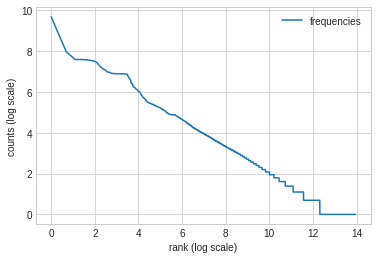

In [26]:
counts = np.load(DS_ITEM_COUNTS_PATH)['y']
print(f'there are {len(counts)} bigrams')
plot_frequencies(counts, 'rank (log scale)', 'counts (log scale)', 'frequencies')

In [27]:
indices = np.argsort(counts)
bigrams = np.load(DS_ITEM_COUNTS_PATH)['x']

print('Top 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[-5:]], counts[indices[-5:]])))

print('Bottom 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[:5]], counts[indices[:5]])))

Top 5 frequent bigrams and their counts:
[('100 females', 1954), ('65 years', 1982), ('0 till', 1985), ('median income', 2885), ('external links', 16118)]
Bottom 5 frequent bigrams and their counts:
[('purely sacerdotal', 1), ('vehicle shall', 1), ('vehicle insignia', 1), ('vehicle trade', 1), ('vehicle proved', 1)]


# Evaluate Original Count-Min and Count-Sketch

In [28]:
### count sketch ###

DATA = DS_ITEM_COUNTS_PATH
SAVE ='cmin_wikicorpus' #save_results to path
SEED = 69
N_HASHES = [1,2,3,4] 
SPACE_LIST = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.4,1.6,1.8,2,3,4] #in MB
N_WORKERS = 7 #n_processes used 
DATA_NAME ='wikicorpus' # determines which script for loading counts is used
COUNT_SKETCH = True

In [29]:
cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for nlp/data/3.0%_wikicorpus_2-grams.npz
data #: 1146052, shape (1146052,)
positive ratio: 1.72754, max 16118.000000, min 1.000000


count_sketch: # hashes 1, # buckets 100000 - loss 7.81	 time: 71.63 sec
count_sketch: # hashes 1, # buckets 25000 - loss 20.24	 time: 72.32 sec
count_sketch: # hashes 1, # buckets 400000 - loss 2.93	 time: 73.56 sec
count_sketch: # hashes 1, # buckets 750000 - loss 1.83	 time: 73.82 sec
count_sketch: # hashes 1, # buckets 175000 - loss 5.30	 time: 74.96 sec
count_sketch: # hashes 1, # buckets 250000 - loss 4.14	 time: 75.58 sec
count_sketch: # hashes 2, # buckets 25000 - loss 18.06	 time: 75.69 sec
count_sketch: # hashes 1, # buckets 50000 - loss 12.60	 time: 72.78 sec
count_sketch: # hashes 1, # buckets 125000 - loss 6.72	 time: 73.70 sec
count_sketch: # hashes 1, # buckets 1000000 - loss 1.52	 time: 73.43 sec
count_sketch: # hashes 1, # buckets 300000 - loss 3.66	 time: 73.99 sec
count_sketch: # hashes 2, # buckets 37500 - loss 12.59	 time: 7

In [30]:
### count min ###

COUNT_SKETCH = False

cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for nlp/data/3.0%_wikicorpus_2-grams.npz
data #: 1146052, shape (1146052,)
positive ratio: 1.72754, max 16118.000000, min 1.000000


count_min: # hashes 1, # buckets 175000 - loss 11.17	 time: 19.17 sec
count_min: # hashes 1, # buckets 400000 - loss 4.84	 time: 19.75 sec
count_min: # hashes 1, # buckets 100000 - loss 19.55	 time: 19.84 sec
count_min: # hashes 1, # buckets 250000 - loss 7.78	 time: 20.09 sec
count_min: # hashes 1, # buckets 750000 - loss 2.57	 time: 20.13 sec
count_min: # hashes 1, # buckets 25000 - loss 78.60	 time: 21.61 sec
count_min: # hashes 2, # buckets 25000 - loss 62.77	 time: 26.17 sec
count_min: # hashes 1, # buckets 200000 - loss 9.82	 time: 18.91 sec
count_min: # hashes 1, # buckets 125000 - loss 15.70	 time: 19.40 sec
count_min: # hashes 1, # buckets 450000 - loss 4.35	 time: 19.72 sec
count_min: # hashes 1, # buckets 300000 - loss 6.59	 time: 19.61 sec
count_min: # hashes 1, # buckets 1000000 - loss 2.05	 time: 21.84 sec
count_min: # hashes 1, #

# Train Estimation Model

## Model Structure

![title](nlp/model.png)

In [3]:
targets, preds, model_size = train_simple_model(config=config,
        args={
            'max_epochs': 10
            })

Global seed set to 123




HYPERPARAMS
-----------
{'args': {'max_epochs': 10}}
{'config': {'batch_size': 128,
            'dropout_prob': 0.0,
            'ds_name': 'wikicorpus',
            'embed_dim': 50,
            'embed_type': 'Glove',
            'hidden_dim': 64,
            'learning_rate': 0.001,
            'limit_prop': 0.03,
            'n': 2,
            'num_workers': 22,
            'op': 'concat',
            'optim': <class 'torch.optim.adam.Adam'>}}


Model_size: 0.026116


GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Loading features from: 
/data/home/daniel_nlp/learning-ds/nlp/data/3.0%_wikicorpus_2-grams_concat_Glove.50_features.npz


1146052it [00:20, 55276.74it/s]


Loading features from: 
/data/home/daniel_nlp/learning-ds/nlp/data/3.0%_wikicorpus_2-grams_concat_Glove.50_features.npz


1146052it [00:21, 54014.91it/s]

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | l1        | Linear  | 6.5 K 
2 | l2        | Linear  | 65    
3 | dropout   | Dropout | 0     
--------------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)


Epoch 0:  57%|█████▋    | 3582/6269 [00:31<00:23, 114.79it/s, loss=0.24, v_num=20] 
Validating: 0it [00:00, ?it/s]
Epoch 0:  97%|█████████▋| 6088/6269 [00:43<00:01, 139.59it/s, loss=0.24, v_num=20]


Epoch 1:  57%|█████▋    | 3582/6269 [00:31<00:23, 115.04it/s, loss=0.235, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 1:  96%|█████████▌| 6014/6269 [00:43<00:01, 139.18it/s, loss=0.235, v_num=20]


Epoch 2:  57%|█████▋    | 3582/6269 [00:32<00:24, 111.75it/s, loss=0.234, v_num=20]
Validating: 0it [00:00, ?it/s]
Validating:  86%|████████▌ | 2310/2687 [00:11<00:01, 253.41it/s]


Epoch 3:  57%|█████▋    | 3582/6269 [00:31<00:23, 114.90it/s, loss=0.233, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 3:  92%|█████████▏| 5797/6269 [00:42<00:03, 136.33it/s, loss=0.233, v_num=20]


Epoch 4:  57%|█████▋    | 3582/6269 [00:32<00:24, 109.11it/s, loss=0.232, v_num=20]
Validating: 0it [00:00, ?it/s]
Validating:  76%|███████▌  | 2030/2687 [00:10<00:02, 243.65it/s]


Epoch 5:  57%|█████▋    | 3582/6269 [00:31<00:23, 112.34it/s, loss=0.232, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 5:  89%|████████▊ | 5549/6269 [00:42<00:05, 132.04it/s, loss=0.232, v_num=20]


Epoch 6:  57%|█████▋    | 3582/6269 [00:31<00:23, 112.74it/s, loss=0.231, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 6:  87%|████████▋ | 5456/6269 [00:41<00:06, 131.24it/s, loss=0.231, v_num=20]


Epoch 7:  57%|█████▋    | 3582/6269 [00:31<00:23, 114.29it/s, loss=0.231, v_num=20]
Validating: 0it [00:00, ?it/s]
Validating:  68%|██████▊   | 1815/2687 [00:09<00:03, 241.39it/s]


Epoch 8:  57%|█████▋    | 3582/6269 [00:31<00:23, 113.98it/s, loss=0.23, v_num=20] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  85%|████████▌ | 5356/6269 [00:40<00:06, 130.91it/s, loss=0.23, v_num=20]


Epoch 9:  57%|█████▋    | 3582/6269 [00:30<00:23, 115.94it/s, loss=0.23, v_num=20] 
Validating: 0it [00:00, ?it/s]
Epoch 9:  85%|████████▍ | 5312/6269 [00:40<00:07, 132.28it/s, loss=0.23, v_num=20]


Epoch 9: 100%|██████████| 6269/6269 [00:44<00:00, 141.69it/s, loss=0.23, v_num=20]
Loading features from: 
/data/home/daniel_nlp/learning-ds/nlp/data/3.0%_wikicorpus_2-grams_concat_Glove.50_features.npz


1146052it [00:28, 40773.82it/s]


Testing: 100%|██████████| 2687/2687 [00:12<00:00, 209.24it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.23505373299121857}
--------------------------------------------------------------------------------
Running prediction on all splits..
dumping test train and validation to:
train test valid
dumping test train and validation predictions to:
/data/home/daniel_nlp/learning-ds/nlp/pred_3.0%_wikicorpus_2-grams_concat_Glove.50.npz


HYPERPARAMS
-----------
{'args': {'max_epochs': 10}}
{'config': {'batch_size': 128,
            'dropout_prob': 0.0,
            'ds_name': 'wikicorpus',
            'embed_dim': 50,
            'embed_type': 'Glove',
            'hidden_dim': 64,
            'learning_rate': 0.001,
            'limit_prop': 0.03,
            'n': 2,
            'num_workers': 22,
            'op': 'concat',
            'optim': <class 'torch.optim.adam.Adam'>}}


targets: {'train': '/data/home/dan

### Model Size

In [17]:
print(f'Trained model size is : {model_size} MB')

Trained model size is : 0.026116 MB


No Skill: ROC AUC=0.50
Learned: ROC AUC=0.84


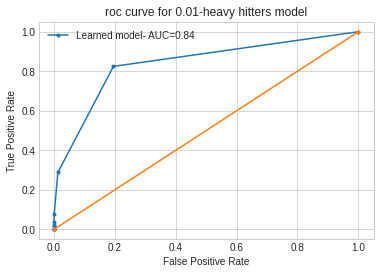

Saving plot...
Done.


<Figure size 432x288 with 0 Axes>

In [39]:
plot_roc(targets=targets, preds=preds, split='test', hh_frac=0.01)

In [19]:
TEST_RESULTS =[f"./nlp/pred_{prec}%_wikicorpus_2-grams_concat_CharNGram.100.npz"]
VALID_RESULTS = [f"./nlp/pred_{prec}%_wikicorpus_2-grams_concat_CharNGram.100.npz"]
TEST_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_test.npz"]
VALID_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz"]
LOOKUP_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_train.npz"]
SAVE ='cmin_wikicorpus'
SEED = 69
SPACE_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 3, 4]
N_HASHES_LIST = [1, 2, 3, 4]
PERFECT_ORDER = False
N_WORKERS = 7
DATA_NAME ='wikicorpus'
COUNT_SKETCH = False

In [7]:
print('Running: no lookup, only using learned model count min...')

LOOKUP_DATA2 = None
PERFECT_ORDER = False

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

Running: no lookup, only using learned model count min...
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-93763452-ac80-4e38-8d0a-b34d66312c56.json

statistics for valid data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 343815, shape (343815,)
positive ratio: 1.72988, max 1985.000000, min 1.000000


statistics for test data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 343815, shape (343815,)
positive ratio: 1.69171, max 1982.000000, min 1.000000


data loading time: 0.6 sec
	loss_cf 0.00	loss_rd 14.52	loss_avg 10.66
cutoff_count_min_param: bcut: 35000, # hashes 1, # buckets 65000 - loss 10.66	 time: 5.44 sec
	loss_cf 0.00	loss_rd 14.60	loss_avg 12.58
cutoff_count_min_param: bcut: 7500, # hashes 1, # buckets 42500 - loss 12.58	 time: 5.76 sec
	loss_cf 0.00	loss_rd 24.79	loss_avg 23.33
cutoff_count_min_param: bcut: 1250, # hashes

	loss_cf 0.00	loss_rd 84.51	loss_avg 77.84
cutoff_count_min_param: bcut: 2500, # hashes 4, # buckets 7500 - loss 77.84	 time: 11.61 sec
	loss_cf 0.00	loss_rd 50.90	loss_avg 43.31
cutoff_count_min_param: bcut: 10000, # hashes 4, # buckets 17500 - loss 43.31	 time: 11.33 sec
	loss_cf 0.00	loss_rd 20.36	loss_avg 15.73
cutoff_count_min_param: bcut: 26250, # hashes 1, # buckets 48750 - loss 15.73	 time: 5.36 sec
	loss_cf 0.00	loss_rd 30.51	loss_avg 27.55
cutoff_count_min_param: bcut: 3750, # hashes 1, # buckets 21250 - loss 27.55	 time: 5.73 sec
	loss_cf 0.00	loss_rd 72.03	loss_avg 49.65
cutoff_count_min_param: bcut: 45000, # hashes 2, # buckets 50000 - loss 49.65	 time: 7.18 sec
	loss_cf 0.00	loss_rd 15.82	loss_avg 14.29
cutoff_count_min_param: bcut: 3750, # hashes 3, # buckets 26250 - loss 14.29	 time: 9.70 sec
	loss_cf 0.00	loss_rd 19.85	loss_avg 16.68
cutoff_count_min_param: bcut: 12500, # hashes 1, # buckets 37500 - loss 16.68	 time: 6.25 sec
	loss_cf 0.00	loss_rd 14.16	loss_avg 11.75


cutoff_count_min_param: bcut: 12500, # hashes 2, # buckets 62500 - loss 5.66	 time: 7.78 sec
	loss_cf 0.00	loss_rd 32.58	loss_avg 26.62
cutoff_count_min_param: bcut: 17500, # hashes 1, # buckets 32500 - loss 26.62	 time: 5.49 sec
	loss_cf 0.00	loss_rd 104.31	loss_avg 77.12
cutoff_count_min_param: bcut: 33750, # hashes 2, # buckets 37500 - loss 77.12	 time: 7.37 sec
	loss_cf 0.00	loss_rd 20.02	loss_avg 15.57
cutoff_count_min_param: bcut: 25000, # hashes 3, # buckets 41666 - loss 15.57	 time: 9.12 sec
	loss_cf 0.00	loss_rd 20.25	loss_avg 17.12
cutoff_count_min_param: bcut: 11250, # hashes 3, # buckets 28750 - loss 17.12	 time: 9.68 sec
	loss_cf 0.00	loss_rd 41.51	loss_avg 36.21
cutoff_count_min_param: bcut: 6250, # hashes 1, # buckets 18750 - loss 36.21	 time: 6.56 sec
	loss_cf 0.00	loss_rd 25.72	loss_avg 23.69
cutoff_count_min_param: bcut: 2500, # hashes 3, # buckets 17500 - loss 23.69	 time: 10.66 sec
	loss_cf 0.00	loss_rd 54.81	loss_avg 44.78
cutoff_count_min_param: bcut: 17500, # has

cutoff_count_min_param: bcut: 40000, # hashes 3, # buckets 80000 - loss 4.58	 time: 8.58 sec
	loss_cf 0.00	loss_rd 2.48	loss_avg 2.10
cutoff_count_min_param: bcut: 11250, # hashes 1, # buckets 213750 - loss 2.10	 time: 5.60 sec
	loss_cf 0.00	loss_rd 3.77	loss_avg 3.25
cutoff_count_min_param: bcut: 7500, # hashes 1, # buckets 142500 - loss 3.25	 time: 5.40 sec
	loss_cf 0.00	loss_rd 10.23	loss_avg 7.05
cutoff_count_min_param: bcut: 45000, # hashes 2, # buckets 75000 - loss 7.05	 time: 7.06 sec
	loss_cf 0.00	loss_rd 10.28	loss_avg 6.15
cutoff_count_min_param: bcut: 70000, # hashes 1, # buckets 105000 - loss 6.15	 time: 5.61 sec
	loss_cf 0.00	loss_rd 12.45	loss_avg 9.68
cutoff_count_min_param: bcut: 25000, # hashes 3, # buckets 50000 - loss 9.68	 time: 8.72 sec
	loss_cf 0.00	loss_rd 2.87	loss_avg 2.43
cutoff_count_min_param: bcut: 11250, # hashes 2, # buckets 112500 - loss 2.43	 time: 7.52 sec
	loss_cf 0.00	loss_rd 4.82	loss_avg 4.15
cutoff_count_min_param: bcut: 7500, # hashes 2, # bucket

cutoff_count_min_param: bcut: 10000, # hashes 2, # buckets 100000 - loss 2.83	 time: 7.84 sec
	loss_cf 0.00	loss_rd 29.21	loss_avg 18.21
cutoff_count_min_param: bcut: 60000, # hashes 3, # buckets 70000 - loss 18.21	 time: 8.14 sec
	loss_cf 0.00	loss_rd 18.64	loss_avg 13.47
cutoff_count_min_param: bcut: 37500, # hashes 3, # buckets 54166 - loss 13.47	 time: 9.13 sec
	loss_cf 0.00	loss_rd 12.33	loss_avg 7.69
cutoff_count_min_param: bcut: 60000, # hashes 4, # buckets 80000 - loss 7.69	 time: 9.81 sec
	loss_cf 0.00	loss_rd 2.81	loss_avg 2.08
cutoff_count_min_param: bcut: 33750, # hashes 1, # buckets 191250 - loss 2.08	 time: 6.03 sec
	loss_cf 0.00	loss_rd 10.22	loss_avg 7.50
cutoff_count_min_param: bcut: 35000, # hashes 4, # buckets 61250 - loss 7.50	 time: 10.04 sec
	loss_cf 0.00	loss_rd 5.87	loss_avg 3.51
cutoff_count_min_param: bcut: 70000, # hashes 1, # buckets 130000 - loss 3.51	 time: 5.03 sec
	loss_cf 0.00	loss_rd 6.00	loss_avg 4.74
cutoff_count_min_param: bcut: 22500, # hashes 2, #

cutoff_count_min_param: bcut: 56250, # hashes 1, # buckets 168750 - loss 2.17	 time: 5.27 sec
	loss_cf 0.00	loss_rd 15.16	loss_avg 9.95
cutoff_count_min_param: bcut: 52500, # hashes 4, # buckets 70000 - loss 9.95	 time: 11.06 sec
	loss_cf 0.00	loss_rd 4.09	loss_avg 3.10
cutoff_count_min_param: bcut: 30000, # hashes 2, # buckets 100000 - loss 3.10	 time: 7.32 sec
	loss_cf 0.00	loss_rd 27.73	loss_avg 15.40
cutoff_count_min_param: bcut: 90000, # hashes 2, # buckets 100000 - loss 15.40	 time: 6.32 sec
	loss_cf 0.00	loss_rd 8.26	loss_avg 5.97
cutoff_count_min_param: bcut: 37500, # hashes 2, # buckets 75000 - loss 5.97	 time: 7.09 sec
	loss_cf 0.00	loss_rd 4.58	loss_avg 2.93
cutoff_count_min_param: bcut: 56250, # hashes 2, # buckets 112500 - loss 2.93	 time: 6.74 sec
	loss_cf 0.00	loss_rd 7.03	loss_avg 4.34
cutoff_count_min_param: bcut: 61250, # hashes 1, # buckets 113750 - loss 4.34	 time: 5.61 sec
	loss_cf 0.00	loss_rd 3.98	loss_avg 2.41
cutoff_count_min_param: bcut: 67500, # hashes 1, # b

cutoff_count_min_param: bcut: 122500, # hashes 4, # buckets 148750 - loss 3.13	 time: 7.85 sec
	loss_cf 0.00	loss_rd 1.58	loss_avg 0.91
cutoff_count_min_param: bcut: 80000, # hashes 2, # buckets 200000 - loss 0.91	 time: 6.47 sec
	loss_cf 0.00	loss_rd 7.36	loss_avg 4.09
cutoff_count_min_param: bcut: 90000, # hashes 1, # buckets 135000 - loss 4.09	 time: 4.74 sec
	loss_cf 0.00	loss_rd 3.63	loss_avg 2.02
cutoff_count_min_param: bcut: 90000, # hashes 2, # buckets 150000 - loss 2.02	 time: 6.09 sec
	loss_cf 0.00	loss_rd 3.77	loss_avg 1.69
cutoff_count_min_param: bcut: 140000, # hashes 1, # buckets 210000 - loss 1.69	 time: 4.14 sec
	loss_cf 0.00	loss_rd 1.85	loss_avg 1.53
cutoff_count_min_param: bcut: 15000, # hashes 1, # buckets 285000 - loss 1.53	 time: 5.51 sec
	loss_cf 0.00	loss_rd 3.38	loss_avg 2.26
cutoff_count_min_param: bcut: 50000, # hashes 2, # buckets 125000 - loss 2.26	 time: 7.19 sec
	loss_cf 0.00	loss_rd 2.16	loss_avg 1.58
cutoff_count_min_param: bcut: 35000, # hashes 3, # bu

cutoff_count_min_param: bcut: 70000, # hashes 2, # buckets 175000 - loss 1.19	 time: 6.63 sec
	loss_cf 0.00	loss_rd 9.97	loss_avg 4.89
cutoff_count_min_param: bcut: 120000, # hashes 3, # buckets 140000 - loss 4.89	 time: 6.90 sec
	loss_cf 0.00	loss_rd 2.91	loss_avg 1.43
cutoff_count_min_param: bcut: 120000, # hashes 3, # buckets 173333 - loss 1.43	 time: 7.11 sec
	loss_cf 0.00	loss_rd 4.82	loss_avg 2.83
cutoff_count_min_param: bcut: 75000, # hashes 2, # buckets 125000 - loss 2.83	 time: 6.60 sec
	loss_cf 0.00	loss_rd 2.48	loss_avg 2.09	loss_cf 0.00	loss_rd 3.56	loss_avg 2.69

cutoff_count_min_param: bcut: 12500, # hashes 2, # buckets 125000 - loss 2.09	 time: 7.66 seccutoff_count_min_param: bcut: 30000, # hashes 4, # buckets 90000 - loss 2.69	 time: 10.55 sec

	loss_cf 0.00	loss_rd 1.62	loss_avg 1.30
cutoff_count_min_param: bcut: 20000, # hashes 3, # buckets 140000 - loss 1.30	 time: 10.44 sec
	loss_cf 0.00	loss_rd 2.64	loss_avg 1.58
cutoff_count_min_param: bcut: 70000, # hashes 3, # b

cutoff_count_min_param: bcut: 175000, # hashes 2, # buckets 250000 - loss 0.62	 time: 4.67 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00
cutoff_count_min_param: bcut: 337500, # hashes 4, # buckets 356250 - loss 0.00	 time: 1.77 sec
	loss_cf 0.00	loss_rd 1.88	loss_avg 0.95
cutoff_count_min_param: bcut: 112500, # hashes 3, # buckets 187500 - loss 0.95	 time: 6.92 sec
	loss_cf 0.00	loss_rd 0.08	loss_avg 0.02
cutoff_count_min_param: bcut: 250000, # hashes 3, # buckets 416666 - loss 0.02	 time: 3.94 sec
	loss_cf 0.00	loss_rd 11.17	loss_avg 4.01
cutoff_count_min_param: bcut: 180000, # hashes 3, # buckets 193333 - loss 4.01	 time: 5.54 sec
	loss_cf 0.00	loss_rd 2.13	loss_avg 0.79
cutoff_count_min_param: bcut: 175000, # hashes 3, # buckets 225000 - loss 0.79	 time: 5.53 sec
	loss_cf 0.00	loss_rd 0.46	loss_avg 0.31
cutoff_count_min_param: bcut: 50000, # hashes 1, # buckets 950000 - loss 0.31	 time: 5.35 sec
	loss_cf 0.00	loss_rd 0.08	loss_avg 0.02
cutoff_count_min_param: bcut: 250000, # hashes 4

cutoff_count_min_param: bcut: 100000, # hashes 2, # buckets 500000 - loss 0.13	 time: 6.47 sec
	loss_cf 0.00	loss_rd 0.99	loss_avg 0.58
cutoff_count_min_param: bcut: 75000, # hashes 1, # buckets 425000 - loss 0.58	 time: 5.36 sec
	loss_cf 0.00	loss_rd 1.69	loss_avg 1.33
cutoff_count_min_param: bcut: 22500, # hashes 4, # buckets 123750 - loss 1.33	 time: 11.47 sec
	loss_cf 0.00	loss_rd 2.87	loss_avg 1.17
cutoff_count_min_param: bcut: 157500, # hashes 3, # buckets 202500 - loss 1.17	 time: 6.20 sec
	loss_cf 0.00	loss_rd 7.53	loss_avg 1.98
cutoff_count_min_param: bcut: 225000, # hashes 4, # buckets 237500 - loss 1.98	 time: 5.02 sec
	loss_cf 0.00	loss_rd 0.54	loss_avg 0.18
cutoff_count_min_param: bcut: 187500, # hashes 4, # buckets 281250 - loss 0.18	 time: 5.77 sec
	loss_cf 0.00	loss_rd 0.24	loss_avg 0.13
cutoff_count_min_param: bcut: 100000, # hashes 3, # buckets 366666 - loss 0.13	 time: 7.82 sec
	loss_cf 0.00	loss_rd 1.12	loss_avg 0.77
cutoff_count_min_param: bcut: 45000, # hashes 1, 

cutoff_count_min_param: bcut: 25000, # hashes 2, # buckets 250000 - loss 0.71	 time: 7.19 sec
	loss_cf 0.00	loss_rd 0.24	loss_avg 0.05
cutoff_count_min_param: bcut: 250000, # hashes 1, # buckets 750000 - loss 0.05	 time: 2.64 sec
	loss_cf 0.00	loss_rd 1.17	loss_avg 0.56
cutoff_count_min_param: bcut: 125000, # hashes 2, # buckets 250000 - loss 0.56	 time: 5.60 sec
	loss_cf 0.00	loss_rd 1.91	loss_avg 1.16
cutoff_count_min_param: bcut: 67500, # hashes 4, # buckets 146250 - loss 1.16	 time: 9.16 sec
	loss_cf 0.00	loss_rd 0.61	loss_avg 0.36
cutoff_count_min_param: bcut: 75000, # hashes 4, # buckets 225000 - loss 0.36	 time: 8.85 sec
	loss_cf 0.00	loss_rd 0.10	loss_avg 0.02
cutoff_count_min_param: bcut: 250000, # hashes 2, # buckets 500000 - loss 0.02	 time: 3.39 sec
	loss_cf 0.00	loss_rd 1.21	loss_avg 0.67
cutoff_count_min_param: bcut: 90000, # hashes 1, # buckets 360000 - loss 0.67	 time: 4.36 sec
	loss_cf 0.00	loss_rd 0.57	loss_avg 0.29
cutoff_count_min_param: bcut: 112500, # hashes 1, # 

In [8]:
print('Running: perfect oracle... only using learned model count min...')

LOOKUP_DATA3=None
PERFECT_ORDER=True

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

Running: perfect oracle... only using learned model count min...
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-93763452-ac80-4e38-8d0a-b34d66312c56.json

statistics for valid data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 343815, shape (343815,)
positive ratio: 1.72988, max 1985.000000, min 1.000000


statistics for test data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 343815, shape (343815,)
positive ratio: 1.69171, max 1982.000000, min 1.000000


data loading time: 0.7 sec
	loss_cf 0.00	loss_rd 11.36	loss_avg 6.51
cutoff_count_min_param_perfect: bcut: 35000, # hashes 1, # buckets 65000 - loss 6.51	 time: 5.23 sec
	loss_cf 0.00	loss_rd 10.32	loss_avg 6.72
cutoff_count_min_param_perfect: bcut: 18750, # hashes 1, # buckets 56250 - loss 6.72	 time: 5.47 sec
	loss_cf 0.00	loss_rd 12.62	loss_avg 9.38
cutoff_count_min_param_pe

	loss_cf 0.00	loss_rd 41.73	loss_avg 26.31
cutoff_count_min_param_perfect: bcut: 22500, # hashes 4, # buckets 30000 - loss 26.31	 time: 10.70 sec
	loss_cf 0.00	loss_rd 47.01	loss_avg 33.71
cutoff_count_min_param_perfect: bcut: 10000, # hashes 4, # buckets 17500 - loss 33.71	 time: 11.17 sec
	loss_cf 0.00	loss_rd 81.99	loss_avg 67.61
cutoff_count_min_param_perfect: bcut: 2500, # hashes 4, # buckets 7500 - loss 67.61	 time: 11.17 sec
	loss_cf 0.00	loss_rd 9.17	loss_avg 6.21
cutoff_count_min_param_perfect: bcut: 15000, # hashes 2, # buckets 50000 - loss 6.21	 time: 7.38 sec
	loss_cf 0.00	loss_rd 32.08	loss_avg 17.30
cutoff_count_min_param_perfect: bcut: 45000, # hashes 1, # buckets 55000 - loss 17.30	 time: 5.12 sec
	loss_cf 0.00	loss_rd 16.17	loss_avg 9.89
cutoff_count_min_param_perfect: bcut: 26250, # hashes 1, # buckets 48750 - loss 9.89	 time: 5.28 sec
	loss_cf 0.00	loss_rd 16.53	loss_avg 11.49
cutoff_count_min_param_perfect: bcut: 12500, # hashes 1, # buckets 37500 - loss 11.49	 time

cutoff_count_min_param_perfect: bcut: 2500, # hashes 2, # buckets 25000 - loss 14.49	 time: 7.80 sec
	loss_cf 0.00	loss_rd 13.14	loss_avg 9.27
cutoff_count_min_param_perfect: bcut: 11250, # hashes 2, # buckets 37500 - loss 9.27	 time: 7.97 sec
	loss_cf 0.00	loss_rd 69.34	loss_avg 46.90
cutoff_count_min_param_perfect: bcut: 15000, # hashes 4, # buckets 20000 - loss 46.90	 time: 11.57 sec
	loss_cf 0.00	loss_rd 106.88	loss_avg 83.01
cutoff_count_min_param_perfect: bcut: 5000, # hashes 4, # buckets 8750 - loss 83.01	 time: 11.76 sec
	loss_cf 0.00	loss_rd 45.74	loss_avg 26.40
cutoff_count_min_param_perfect: bcut: 33750, # hashes 1, # buckets 41250 - loss 26.40	 time: 5.25 sec
	loss_cf 0.00	loss_rd 12.25	loss_avg 7.57
cutoff_count_min_param_perfect: bcut: 25000, # hashes 2, # buckets 50000 - loss 7.57	 time: 9.83 sec
	loss_cf 0.00	loss_rd 6.26	loss_avg 4.35
cutoff_count_min_param_perfect: bcut: 12500, # hashes 2, # buckets 62500 - loss 4.35	 time: 7.58 sec
	loss_cf 0.00	loss_rd 26.17	loss_av

	loss_cf 0.00	loss_rd 13.32	loss_avg 7.52
cutoff_count_min_param_perfect: bcut: 37500, # hashes 4, # buckets 56250 - loss 7.52	 time: 10.43 sec
	loss_cf 0.00	loss_rd 4.90	loss_avg 3.03
cutoff_count_min_param_perfect: bcut: 25000, # hashes 1, # buckets 100000 - loss 3.03	 time: 5.39 sec
	loss_cf 0.00	loss_rd 4.10	loss_avg 2.28
cutoff_count_min_param_perfect: bcut: 40000, # hashes 2, # buckets 100000 - loss 2.28	 time: 7.32 sec
	loss_cf 0.00	loss_rd 5.34	loss_avg 2.88
cutoff_count_min_param_perfect: bcut: 45000, # hashes 1, # buckets 105000 - loss 2.88	 time: 5.36 sec
	loss_cf 0.00	loss_rd 5.59	loss_avg 3.69
cutoff_count_min_param_perfect: bcut: 17500, # hashes 3, # buckets 64166 - loss 3.69	 time: 9.53 sec
	loss_cf 0.00	loss_rd 17.15	loss_avg 8.31
cutoff_count_min_param_perfect: bcut: 61250, # hashes 4, # buckets 74375 - loss 8.31	 time: 9.46 sec
	loss_cf 0.00	loss_rd 7.80	loss_avg 4.82
cutoff_count_min_param_perfect: bcut: 25000, # hashes 2, # buckets 62500 - loss 4.82	 time: 7.51 sec


cutoff_count_min_param_perfect: bcut: 15000, # hashes 3, # buckets 55000 - loss 4.67	 time: 9.18 sec
	loss_cf 0.00	loss_rd 9.71	loss_avg 4.75
cutoff_count_min_param_perfect: bcut: 60000, # hashes 1, # buckets 90000 - loss 4.75	 time: 4.92 sec
	loss_cf 0.00	loss_rd 5.73	loss_avg 2.80
cutoff_count_min_param_perfect: bcut: 60000, # hashes 2, # buckets 100000 - loss 2.80	 time: 6.96 sec
	loss_cf 0.00	loss_rd 3.91	loss_avg 2.47
cutoff_count_min_param_perfect: bcut: 22500, # hashes 3, # buckets 82500 - loss 2.47	 time: 9.01 sec
	loss_cf 0.00	loss_rd 2.37	loss_avg 1.70
cutoff_count_min_param_perfect: bcut: 10000, # hashes 1, # buckets 190000 - loss 1.70	 time: 5.43 sec
	loss_cf 0.00	loss_rd 6.94	loss_avg 3.98
cutoff_count_min_param_perfect: bcut: 35000, # hashes 3, # buckets 70000 - loss 3.98	 time: 8.71 sec
	loss_cf 0.00	loss_rd 11.21	loss_avg 6.33
cutoff_count_min_param_perfect: bcut: 37500, # hashes 2, # buckets 62500 - loss 6.33	 time: 7.87 sec
	loss_cf 0.00	loss_rd 16.85	loss_avg 8.24
cu

cutoff_count_min_param_perfect: bcut: 20000, # hashes 4, # buckets 60000 - loss 3.88	 time: 10.84 sec
	loss_cf 0.00	loss_rd 9.97	loss_avg 5.12
cutoff_count_min_param_perfect: bcut: 52500, # hashes 3, # buckets 75833 - loss 5.12	 time: 8.34 sec
	loss_cf 0.00	loss_rd 8.62	loss_avg 5.11
cutoff_count_min_param_perfect: bcut: 30000, # hashes 3, # buckets 60000 - loss 5.11	 time: 9.11 sec
	loss_cf 0.00	loss_rd 3.79	loss_avg 2.77
cutoff_count_min_param_perfect: bcut: 8750, # hashes 2, # buckets 87500 - loss 2.77	 time: 7.55 sec
	loss_cf 0.00	loss_rd 4.80	loss_avg 2.59
cutoff_count_min_param_perfect: bcut: 45000, # hashes 3, # buckets 90000 - loss 2.59	 time: 8.46 sec
	loss_cf 0.00	loss_rd 16.08	loss_avg 7.13
cutoff_count_min_param_perfect: bcut: 80000, # hashes 3, # buckets 93333 - loss 7.13	 time: 7.94 sec
	loss_cf 0.00	loss_rd 2.52	loss_avg 1.49
cutoff_count_min_param_perfect: bcut: 30000, # hashes 1, # buckets 170000 - loss 1.49	 time: 5.21 sec
	loss_cf 0.00	loss_rd 21.91	loss_avg 11.45
cu

cutoff_count_min_param_perfect: bcut: 112500, # hashes 2, # buckets 125000 - loss 6.26	 time: 6.04 sec
	loss_cf 0.00	loss_rd 1.67	loss_avg 0.82
cutoff_count_min_param_perfect: bcut: 60000, # hashes 3, # buckets 153333 - loss 0.82	 time: 8.19 sec
	loss_cf 0.00	loss_rd 6.29	loss_avg 2.80
cutoff_count_min_param_perfect: bcut: 78750, # hashes 2, # buckets 112500 - loss 2.80	 time: 6.66 sec
	loss_cf 0.00	loss_rd 3.49	loss_avg 1.58
cutoff_count_min_param_perfect: bcut: 75000, # hashes 3, # buckets 125000 - loss 1.58	 time: 7.87 sec
	loss_cf 0.00	loss_rd 3.64	loss_avg 2.06
cutoff_count_min_param_perfect: bcut: 37500, # hashes 3, # buckets 95833 - loss 2.06	 time: 9.21 sec
	loss_cf 0.00	loss_rd 1.21	loss_avg 0.70
cutoff_count_min_param_perfect: bcut: 35000, # hashes 1, # buckets 315000 - loss 0.70	 time: 5.33 sec
	loss_cf 0.00	loss_rd 4.26	loss_avg 1.59
cutoff_count_min_param_perfect: bcut: 122500, # hashes 3, # buckets 157500 - loss 1.59	 time: 7.51 sec
	loss_cf 0.00	loss_rd 23.36	loss_avg 9.

cutoff_count_min_param_perfect: bcut: 101250, # hashes 2, # buckets 112500 - loss 7.72	 time: 6.01 sec
	loss_cf 0.00	loss_rd 2.73	loss_avg 1.40
cutoff_count_min_param_perfect: bcut: 52500, # hashes 4, # buckets 113750 - loss 1.40	 time: 9.45 sec
	loss_cf 0.00	loss_rd 3.37	loss_avg 1.62
cutoff_count_min_param_perfect: bcut: 62500, # hashes 2, # buckets 125000 - loss 1.62	 time: 6.79 sec
	loss_cf 0.00	loss_rd 16.65	loss_avg 5.22
cutoff_count_min_param_perfect: bcut: 157500, # hashes 4, # buckets 166250 - loss 5.22	 time: 7.05 sec
	loss_cf 0.00	loss_rd 1.30	loss_avg 0.60
cutoff_count_min_param_perfect: bcut: 70000, # hashes 1, # buckets 280000 - loss 0.60	 time: 4.53 sec
	loss_cf 0.00	loss_rd 1.89	loss_avg 1.12
cutoff_count_min_param_perfect: bcut: 30000, # hashes 2, # buckets 150000 - loss 1.12	 time: 7.56 sec
	loss_cf 0.00	loss_rd 2.73	loss_avg 1.12
cutoff_count_min_param_perfect: bcut: 100000, # hashes 4, # buckets 150000 - loss 1.12	 time: 8.31 sec
	loss_cf 0.00	loss_rd 7.37	loss_avg 

cutoff_count_min_param_perfect: bcut: 45000, # hashes 4, # buckets 97500 - loss 1.91	 time: 10.71 sec
	loss_cf 0.00	loss_rd 1.70	loss_avg 0.68
cutoff_count_min_param_perfect: bcut: 105000, # hashes 1, # buckets 245000 - loss 0.68	 time: 4.13 sec
	loss_cf 0.00	loss_rd 1.59	loss_avg 0.89
cutoff_count_min_param_perfect: bcut: 40000, # hashes 3, # buckets 146666 - loss 0.89	 time: 9.38 sec
	loss_cf 0.00	loss_rd 4.74	loss_avg 1.46
cutoff_count_min_param_perfect: bcut: 160000, # hashes 3, # buckets 186666 - loss 1.46	 time: 6.12 sec
	loss_cf 0.00	loss_rd 5.38	loss_avg 2.32
cutoff_count_min_param_perfect: bcut: 87500, # hashes 2, # buckets 125000 - loss 2.32	 time: 6.62 sec
	loss_cf 0.00	loss_rd 3.40	loss_avg 1.05
cutoff_count_min_param_perfect: bcut: 160000, # hashes 2, # buckets 200000 - loss 1.05	 time: 5.35 sec
	loss_cf 0.00	loss_rd 1.62	loss_avg 0.79
cutoff_count_min_param_perfect: bcut: 60000, # hashes 1, # buckets 240000 - loss 0.79	 time: 5.32 sec
	loss_cf 0.00	loss_rd 2.39	loss_avg 0

cutoff_count_min_param_perfect: bcut: 350000, # hashes 3, # buckets 450000 - loss 0.00	 time: 1.60 sec
	loss_cf 0.00	loss_rd 1.07	loss_avg 0.56
cutoff_count_min_param_perfect: bcut: 50000, # hashes 3, # buckets 183333 - loss 0.56	 time: 8.22 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 350000, # hashes 4, # buckets 425000 - loss 0.00	 time: 1.57 sec
	loss_cf 0.00	loss_rd 3.40	loss_avg 0.82
cutoff_count_min_param_perfect: bcut: 200000, # hashes 4, # buckets 225000 - loss 0.82	 time: 5.58 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 400000, # hashes 1, # buckets 600000 - loss 0.00	 time: 1.57 sec
	loss_cf 0.00	loss_rd 1.98	loss_avg 0.69
cutoff_count_min_param_perfect: bcut: 135000, # hashes 3, # buckets 195000 - loss 0.69	 time: 6.73 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 400000, # hashes 2, # buckets 500000 - loss 0.00	 time: 1.52 sec
	loss_cf 0.00	loss_rd 2.37	loss_av

	loss_cf 0.00	loss_rd 0.19	loss_avg 0.06
cutoff_count_min_param_perfect: bcut: 150000, # hashes 3, # buckets 383333 - loss 0.06	 time: 6.15 sec
	loss_cf 0.00	loss_rd 0.61	loss_avg 0.34
cutoff_count_min_param_perfect: bcut: 37500, # hashes 4, # buckets 206250 - loss 0.34	 time: 10.03 sec
	loss_cf 0.00	loss_rd 0.32	loss_avg 0.04
cutoff_count_min_param_perfect: bcut: 262500, # hashes 3, # buckets 337500 - loss 0.04	 time: 3.40 sec
	loss_cf 0.00	loss_rd 1.65	loss_avg 0.89
cutoff_count_min_param_perfect: bcut: 45000, # hashes 4, # buckets 135000 - loss 0.89	 time: 9.80 sec
	loss_cf 0.00	loss_rd 0.94	loss_avg 0.38
cutoff_count_min_param_perfect: bcut: 100000, # hashes 2, # buckets 250000 - loss 0.38	 time: 6.23 sec
	loss_cf 0.00	loss_rd 4.61	loss_avg 1.27
cutoff_count_min_param_perfect: bcut: 180000, # hashes 4, # buckets 202500 - loss 1.27	 time: 5.87 sec
	loss_cf 0.00	loss_rd 0.37	loss_avg 0.05
cutoff_count_min_param_perfect: bcut: 262500, # hashes 4, # buckets 318750 - loss 0.05	 time: 3.

	loss_cf 0.00	loss_rd 1.30	loss_avg 0.61
cutoff_count_min_param_perfect: bcut: 70000, # hashes 1, # buckets 280000 - loss 0.61	 time: 5.01 sec
	loss_cf 0.00	loss_rd 2.07	loss_avg 1.10
cutoff_count_min_param_perfect: bcut: 50000, # hashes 1, # buckets 200000 - loss 1.10	 time: 5.25 sec
	loss_cf 0.00	loss_rd 2.51	loss_avg 1.52
cutoff_count_min_param_perfect: bcut: 30000, # hashes 1, # buckets 170000 - loss 1.52	 time: 5.54 sec
	loss_cf 0.00	loss_rd 2.17	loss_avg 1.28
cutoff_count_min_param_perfect: bcut: 33750, # hashes 1, # buckets 191250 - loss 1.28	 time: 5.57 sec
	loss_cf 0.00	loss_rd 1.61	loss_avg 0.81
cutoff_count_min_param_perfect: bcut: 60000, # hashes 1, # buckets 240000 - loss 0.81	 time: 5.91 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 337500, # hashes 4, # buckets 356250 - loss 0.00	 time: 1.63 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 350000, # hashes 1, # buckets 650000 - loss 0.00	 time: 1.60 s

# Plot Count-Min

plot testing results for perfect CCM


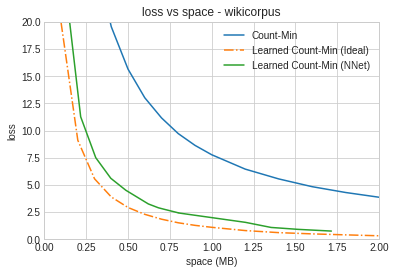

In [21]:
ALGO = 'Count-Min'
COUNT_MIN = 'param_results/count_min/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_min_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_min_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_min/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Min (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [model_size]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=None,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()

In [11]:
print('Running: no lookup, only using learned model count sketch...')

LOOKUP_DATA2 = None
PERFECT_ORDER = False

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

Running: no lookup, only using learned model count sketch...
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-93763452-ac80-4e38-8d0a-b34d66312c56.json

statistics for valid data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 343815, shape (343815,)
positive ratio: 1.72988, max 1985.000000, min 1.000000


statistics for test data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 343815, shape (343815,)
positive ratio: 1.69171, max 1982.000000, min 1.000000


data loading time: 0.6 sec
	loss_cf 0.00	loss_rd 14.52	loss_avg 10.66
cutoff_count_min_param: bcut: 35000, # hashes 1, # buckets 65000 - loss 10.66	 time: 5.42 sec
	loss_cf 0.00	loss_rd 12.95	loss_avg 10.50
cutoff_count_min_param: bcut: 18750, # hashes 1, # buckets 56250 - loss 10.50	 time: 5.56 sec
	loss_cf 0.00	loss_rd 14.60	loss_avg 12.58
cutoff_count_min_param: bcut: 7500, # ha

	loss_cf 0.00	loss_rd 11.21	loss_avg 10.12
cutoff_count_min_param: bcut: 3750, # hashes 2, # buckets 37500 - loss 10.12	 time: 7.74 sec
	loss_cf 0.00	loss_rd 40.89	loss_avg 28.19
cutoff_count_min_param: bcut: 45000, # hashes 1, # buckets 55000 - loss 28.19	 time: 4.91 sec
	loss_cf 0.00	loss_rd 20.36	loss_avg 15.73
cutoff_count_min_param: bcut: 26250, # hashes 1, # buckets 48750 - loss 15.73	 time: 5.07 sec
	loss_cf 0.00	loss_rd 19.85	loss_avg 16.68
cutoff_count_min_param: bcut: 12500, # hashes 1, # buckets 37500 - loss 16.68	 time: 5.80 sec
	loss_cf 0.00	loss_rd 30.51	loss_avg 27.55
cutoff_count_min_param: bcut: 3750, # hashes 1, # buckets 21250 - loss 27.55	 time: 5.76 sec
	loss_cf 0.00	loss_rd 267.99	loss_avg 228.03
cutoff_count_min_param: bcut: 10000, # hashes 3, # buckets 11666 - loss 228.03	 time: 9.66 sec
	loss_cf 0.00	loss_rd 72.03	loss_avg 49.65
cutoff_count_min_param: bcut: 45000, # hashes 2, # buckets 50000 - loss 49.65	 time: 6.82 sec
	loss_cf 0.00	loss_rd 33.73	loss_avg 26.

cutoff_count_min_param: bcut: 17500, # hashes 1, # buckets 32500 - loss 26.62	 time: 5.30 sec
	loss_cf 0.00	loss_rd 104.31	loss_avg 77.12
cutoff_count_min_param: bcut: 33750, # hashes 2, # buckets 37500 - loss 77.12	 time: 6.98 sec
	loss_cf 0.00	loss_rd 41.51	loss_avg 36.21
cutoff_count_min_param: bcut: 6250, # hashes 1, # buckets 18750 - loss 36.21	 time: 5.51 sec
	loss_cf 0.00	loss_rd 25.72	loss_avg 23.69
cutoff_count_min_param: bcut: 2500, # hashes 3, # buckets 17500 - loss 23.69	 time: 9.40 sec
	loss_cf 0.00	loss_rd 20.02	loss_avg 15.57
cutoff_count_min_param: bcut: 25000, # hashes 3, # buckets 41666 - loss 15.57	 time: 8.99 sec
	loss_cf 0.00	loss_rd 6.74	loss_avg 5.66
cutoff_count_min_param: bcut: 12500, # hashes 2, # buckets 62500 - loss 5.66	 time: 8.43 sec
	loss_cf 0.00	loss_rd 20.25	loss_avg 17.12
cutoff_count_min_param: bcut: 11250, # hashes 3, # buckets 28750 - loss 17.12	 time: 9.21 sec
	loss_cf 0.00	loss_rd 54.81	loss_avg 44.78
cutoff_count_min_param: bcut: 17500, # hashes

cutoff_count_min_param: bcut: 70000, # hashes 1, # buckets 105000 - loss 6.16	 time: 4.81 sec
	loss_cf 0.00	loss_rd 6.44	loss_avg 4.58
cutoff_count_min_param: bcut: 40000, # hashes 3, # buckets 80000 - loss 4.58	 time: 8.82 sec
	loss_cf 0.00	loss_rd 2.48	loss_avg 2.10
cutoff_count_min_param: bcut: 11250, # hashes 1, # buckets 213750 - loss 2.10	 time: 5.74 sec
	loss_cf 0.00	loss_rd 3.77	loss_avg 3.25
cutoff_count_min_param: bcut: 7500, # hashes 1, # buckets 142500 - loss 3.25	 time: 5.42 sec
	loss_cf 0.00	loss_rd 10.23	loss_avg 7.05
cutoff_count_min_param: bcut: 45000, # hashes 2, # buckets 75000 - loss 7.05	 time: 7.12 sec
	loss_cf 0.00	loss_rd 16.41	loss_avg 9.82
cutoff_count_min_param: bcut: 70000, # hashes 2, # buckets 87500 - loss 9.82	 time: 6.42 sec
	loss_cf 0.00	loss_rd 7.81	loss_avg 6.38
cutoff_count_min_param: bcut: 17500, # hashes 4, # buckets 52500 - loss 6.38	 time: 10.92 sec
	loss_cf 0.00	loss_rd 12.45	loss_avg 9.68
cutoff_count_min_param: bcut: 25000, # hashes 3, # bucke

cutoff_count_min_param: bcut: 33750, # hashes 1, # buckets 191250 - loss 2.08	 time: 5.57 sec
	loss_cf 0.00	loss_rd 10.21	loss_avg 7.50
cutoff_count_min_param: bcut: 35000, # hashes 4, # buckets 61250 - loss 7.50	 time: 10.56 sec
	loss_cf 0.00	loss_rd 4.45	loss_avg 3.51
cutoff_count_min_param: bcut: 22500, # hashes 1, # buckets 127500 - loss 3.51	 time: 6.28 sec
	loss_cf 0.00	loss_rd 12.33	loss_avg 7.69
cutoff_count_min_param: bcut: 60000, # hashes 4, # buckets 80000 - loss 7.69	 time: 9.69 sec
	loss_cf 0.00	loss_rd 18.64	loss_avg 13.47
cutoff_count_min_param: bcut: 37500, # hashes 3, # buckets 54166 - loss 13.47	 time: 8.57 sec
	loss_cf 0.00	loss_rd 29.21	loss_avg 18.21
cutoff_count_min_param: bcut: 60000, # hashes 3, # buckets 70000 - loss 18.21	 time: 8.47 sec
	loss_cf 0.00	loss_rd 4.48	loss_avg 3.81
cutoff_count_min_param: bcut: 10000, # hashes 3, # buckets 70000 - loss 3.81	 time: 9.34 sec
	loss_cf 0.00	loss_rd 3.47	loss_avg 2.57
cutoff_count_min_param: bcut: 33750, # hashes 2, # 

cutoff_count_min_param: bcut: 30000, # hashes 2, # buckets 100000 - loss 3.09	 time: 8.15 sec
	loss_cf 0.00	loss_rd 5.37	loss_avg 4.60
cutoff_count_min_param: bcut: 8750, # hashes 3, # buckets 61250 - loss 4.60	 time: 9.76 sec
	loss_cf 0.00	loss_rd 4.58	loss_avg 2.93
cutoff_count_min_param: bcut: 56250, # hashes 2, # buckets 112500 - loss 2.93	 time: 7.01 sec
	loss_cf 0.00	loss_rd 5.74	loss_avg 4.14
cutoff_count_min_param: bcut: 37500, # hashes 1, # buckets 112500 - loss 4.14	 time: 5.36 sec
	loss_cf 0.00	loss_rd 6.97	loss_avg 4.31
cutoff_count_min_param: bcut: 61250, # hashes 1, # buckets 113750 - loss 4.31	 time: 5.09 sec
	loss_cf 0.00	loss_rd 27.73	loss_avg 15.40
cutoff_count_min_param: bcut: 90000, # hashes 2, # buckets 100000 - loss 15.40	 time: 6.24 sec
	loss_cf 0.00	loss_rd 5.60	loss_avg 4.24
cutoff_count_min_param: bcut: 30000, # hashes 3, # buckets 76666 - loss 4.24	 time: 8.95 sec
	loss_cf 0.00	loss_rd 50.03	loss_avg 33.40
cutoff_count_min_param: bcut: 50000, # hashes 4, # bu

cutoff_count_min_param: bcut: 112500, # hashes 4, # buckets 118750 - loss 18.98	 time: 8.36 sec
	loss_cf 0.00	loss_rd 2.59	loss_avg 1.73
cutoff_count_min_param: bcut: 50000, # hashes 1, # buckets 200000 - loss 1.73	 time: 4.86 sec
	loss_cf 0.00	loss_rd 13.95	loss_avg 8.09
cutoff_count_min_param: bcut: 78750, # hashes 4, # buckets 95625 - loss 8.09	 time: 9.84 sec
	loss_cf 0.00	loss_rd 2.16	loss_avg 1.58
cutoff_count_min_param: bcut: 35000, # hashes 3, # buckets 128333 - loss 1.58	 time: 8.81 sec
	loss_cf 0.00	loss_rd 5.30	loss_avg 2.37
cutoff_count_min_param: bcut: 140000, # hashes 2, # buckets 175000 - loss 2.37	 time: 5.05 sec
	loss_cf 0.00	loss_rd 1.85	loss_avg 1.54
cutoff_count_min_param: bcut: 15000, # hashes 1, # buckets 285000 - loss 1.54	 time: 5.78 sec
	loss_cf 0.00	loss_rd 3.63	loss_avg 2.02
cutoff_count_min_param: bcut: 90000, # hashes 2, # buckets 150000 - loss 2.02	 time: 6.24 sec
	loss_cf 0.00	loss_rd 3.35	loss_avg 2.24
cutoff_count_min_param: bcut: 50000, # hashes 2, # b

cutoff_count_min_param: bcut: 120000, # hashes 3, # buckets 173333 - loss 1.43	 time: 6.50 sec
	loss_cf 0.00	loss_rd 1.62	loss_avg 1.30
cutoff_count_min_param: bcut: 20000, # hashes 3, # buckets 140000 - loss 1.30	 time: 9.37 sec
	loss_cf 0.00	loss_rd 2.21	loss_avg 1.86
cutoff_count_min_param: bcut: 12500, # hashes 1, # buckets 237500 - loss 1.86	 time: 5.36 sec
	loss_cf 0.00	loss_rd 2.64	loss_avg 1.58
cutoff_count_min_param: bcut: 70000, # hashes 3, # buckets 140000 - loss 1.58	 time: 7.99 sec
	loss_cf 0.00	loss_rd 4.85	loss_avg 2.85
cutoff_count_min_param: bcut: 75000, # hashes 2, # buckets 125000 - loss 2.85	 time: 6.12 sec
	loss_cf 0.00	loss_rd 10.04	loss_avg 4.92
cutoff_count_min_param: bcut: 120000, # hashes 3, # buckets 140000 - loss 4.92	 time: 6.73 sec
	loss_cf 0.00	loss_rd 3.55	loss_avg 2.68
cutoff_count_min_param: bcut: 30000, # hashes 4, # buckets 90000 - loss 2.68	 time: 10.66 sec
	loss_cf 0.00	loss_rd 3.76	loss_avg 1.84
cutoff_count_min_param: bcut: 120000, # hashes 4, # 

cutoff_count_min_param: bcut: 250000, # hashes 3, # buckets 416666 - loss 0.02	 time: 4.13 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00
cutoff_count_min_param: bcut: 337500, # hashes 3, # buckets 362500 - loss 0.00	 time: 1.58 sec
	loss_cf 0.00	loss_rd 2.15	loss_avg 0.80
cutoff_count_min_param: bcut: 175000, # hashes 3, # buckets 225000 - loss 0.80	 time: 5.81 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00
cutoff_count_min_param: bcut: 337500, # hashes 4, # buckets 356250 - loss 0.00	 time: 1.84 sec
	loss_cf 0.00	loss_rd 7.86	loss_avg 2.82
cutoff_count_min_param: bcut: 180000, # hashes 2, # buckets 200000 - loss 2.82	 time: 4.80 sec
	loss_cf 0.00	loss_rd 0.08	loss_avg 0.02
cutoff_count_min_param: bcut: 250000, # hashes 4, # buckets 375000 - loss 0.02	 time: 4.64 sec
	loss_cf 0.00	loss_rd 1.40	loss_avg 1.09
cutoff_count_min_param: bcut: 25000, # hashes 4, # buckets 137500 - loss 1.09	 time: 10.49 sec
	loss_cf 0.00	loss_rd 0.59	loss_avg 0.30
cutoff_count_min_param: bcut: 112500, # hashes 4

cutoff_count_min_param: bcut: 187500, # hashes 3, # buckets 312500 - loss 0.15	 time: 4.98 sec
	loss_cf 0.00	loss_rd 7.52	loss_avg 1.97
cutoff_count_min_param: bcut: 225000, # hashes 4, # buckets 237500 - loss 1.97	 time: 5.07 sec
	loss_cf 0.00	loss_rd 2.85	loss_avg 1.16
cutoff_count_min_param: bcut: 157500, # hashes 3, # buckets 202500 - loss 1.16	 time: 5.79 sec
	loss_cf 0.00	loss_rd 0.24	loss_avg 0.13
cutoff_count_min_param: bcut: 100000, # hashes 2, # buckets 500000 - loss 0.13	 time: 6.08 sec
	loss_cf 0.00	loss_rd 0.98	loss_avg 0.57
cutoff_count_min_param: bcut: 75000, # hashes 2, # buckets 250000 - loss 0.57	 time: 6.27 sec
	loss_cf 0.00	loss_rd 0.53	loss_avg 0.18
cutoff_count_min_param: bcut: 187500, # hashes 4, # buckets 281250 - loss 0.18	 time: 6.46 sec
	loss_cf 0.00	loss_rd 0.62	loss_avg 0.45
cutoff_count_min_param: bcut: 37500, # hashes 1, # buckets 712500 - loss 0.45	 time: 5.21 sec
	loss_cf 0.00	loss_rd 1.70	loss_avg 1.34
cutoff_count_min_param: bcut: 22500, # hashes 4, #

cutoff_count_min_param: bcut: 25000, # hashes 2, # buckets 250000 - loss 0.71	 time: 6.77 sec
	loss_cf 0.00	loss_rd 0.15	loss_avg 0.05
cutoff_count_min_param: bcut: 200000, # hashes 4, # buckets 350000 - loss 0.05	 time: 5.83 sec
	loss_cf 0.00	loss_rd 0.60	loss_avg 0.35
cutoff_count_min_param: bcut: 75000, # hashes 4, # buckets 225000 - loss 0.35	 time: 9.45 sec
	loss_cf 0.00	loss_rd 0.24	loss_avg 0.05
cutoff_count_min_param: bcut: 250000, # hashes 1, # buckets 750000 - loss 0.05	 time: 2.75 sec
	loss_cf 0.00	loss_rd 1.49	loss_avg 0.71
cutoff_count_min_param: bcut: 125000, # hashes 3, # buckets 208333 - loss 0.71	 time: 6.28 sec
	loss_cf 0.00	loss_rd 0.56	loss_avg 0.29
cutoff_count_min_param: bcut: 112500, # hashes 1, # buckets 637500 - loss 0.29	 time: 3.91 sec
	loss_cf 0.00	loss_rd 0.10	loss_avg 0.02
cutoff_count_min_param: bcut: 250000, # hashes 2, # buckets 500000 - loss 0.02	 time: 3.15 sec
	loss_cf 0.00	loss_rd 1.90	loss_avg 1.15
cutoff_count_min_param: bcut: 67500, # hashes 4, #

In [12]:
print('Running: perfect oracle... only using learned model count sketch...')

LOOKUP_DATA3=None
PERFECT_ORDER=True

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

Running: perfect oracle... only using learned model count sketch...
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-93763452-ac80-4e38-8d0a-b34d66312c56.json

statistics for valid data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 343815, shape (343815,)
positive ratio: 1.72988, max 1985.000000, min 1.000000


statistics for test data:
./nlp/true_3.0%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 343815, shape (343815,)
positive ratio: 1.69171, max 1982.000000, min 1.000000


data loading time: 0.7 sec
	loss_cf 0.00	loss_rd 11.36	loss_avg 6.51
cutoff_count_min_param_perfect: bcut: 35000, # hashes 1, # buckets 65000 - loss 6.51	 time: 5.29 sec
	loss_cf 0.00	loss_rd 12.62	loss_avg 9.38
cutoff_count_min_param_perfect: bcut: 7500, # hashes 1, # buckets 42500 - loss 9.38	 time: 5.52 sec
	loss_cf 0.00	loss_rd 10.32	loss_avg 6.72
cutoff_count_min_param_

	loss_cf 0.00	loss_rd 41.73	loss_avg 26.31
cutoff_count_min_param_perfect: bcut: 22500, # hashes 4, # buckets 30000 - loss 26.31	 time: 11.28 sec
	loss_cf 0.00	loss_rd 10.90	loss_avg 8.69
cutoff_count_min_param_perfect: bcut: 3750, # hashes 2, # buckets 37500 - loss 8.69	 time: 8.15 sec
	loss_cf 0.00	loss_rd 160.97	loss_avg 115.43
cutoff_count_min_param_perfect: bcut: 10000, # hashes 2, # buckets 12500 - loss 115.43	 time: 8.00 sec
	loss_cf 0.00	loss_rd 47.01	loss_avg 33.71
cutoff_count_min_param_perfect: bcut: 10000, # hashes 4, # buckets 17500 - loss 33.71	 time: 10.83 sec
	loss_cf 0.00	loss_rd 81.99	loss_avg 67.61
cutoff_count_min_param_perfect: bcut: 2500, # hashes 4, # buckets 7500 - loss 67.61	 time: 12.34 sec
	loss_cf 0.00	loss_rd 16.17	loss_avg 9.89
cutoff_count_min_param_perfect: bcut: 26250, # hashes 1, # buckets 48750 - loss 9.89	 time: 5.57 sec
	loss_cf 0.00	loss_rd 59.34	loss_avg 32.00
cutoff_count_min_param_perfect: bcut: 45000, # hashes 2, # buckets 50000 - loss 32.00	 t

cutoff_count_min_param_perfect: bcut: 12500, # hashes 1, # buckets 112500 - loss 2.88	 time: 5.59 sec
	loss_cf 0.00	loss_rd 13.14	loss_avg 9.27
cutoff_count_min_param_perfect: bcut: 11250, # hashes 2, # buckets 37500 - loss 9.27	 time: 7.57 sec
	loss_cf 0.00	loss_rd 45.74	loss_avg 26.40
cutoff_count_min_param_perfect: bcut: 33750, # hashes 1, # buckets 41250 - loss 26.40	 time: 5.14 sec
	loss_cf 0.00	loss_rd 17.58	loss_avg 14.49
cutoff_count_min_param_perfect: bcut: 2500, # hashes 2, # buckets 25000 - loss 14.49	 time: 7.80 sec
	loss_cf 0.00	loss_rd 69.34	loss_avg 46.90
cutoff_count_min_param_perfect: bcut: 15000, # hashes 4, # buckets 20000 - loss 46.90	 time: 11.22 sec
	loss_cf 0.00	loss_rd 106.88	loss_avg 83.01
cutoff_count_min_param_perfect: bcut: 5000, # hashes 4, # buckets 8750 - loss 83.01	 time: 11.21 sec
	loss_cf 0.00	loss_rd 6.26	loss_avg 4.35
cutoff_count_min_param_perfect: bcut: 12500, # hashes 2, # buckets 62500 - loss 4.35	 time: 7.61 sec
	loss_cf 0.00	loss_rd 17.62	loss_

	loss_cf 0.00	loss_rd 32.92	loss_avg 14.05
cutoff_count_min_param_perfect: bcut: 90000, # hashes 3, # buckets 96666 - loss 14.05	 time: 7.53 sec
	loss_cf 0.00	loss_rd 4.10	loss_avg 2.28
cutoff_count_min_param_perfect: bcut: 40000, # hashes 2, # buckets 100000 - loss 2.28	 time: 6.96 sec
	loss_cf 0.00	loss_rd 13.33	loss_avg 7.52
cutoff_count_min_param_perfect: bcut: 37500, # hashes 4, # buckets 56250 - loss 7.52	 time: 10.67 sec
	loss_cf 0.00	loss_rd 17.15	loss_avg 8.31
cutoff_count_min_param_perfect: bcut: 61250, # hashes 4, # buckets 74375 - loss 8.31	 time: 9.88 sec
	loss_cf 0.00	loss_rd 7.80	loss_avg 4.82
cutoff_count_min_param_perfect: bcut: 25000, # hashes 2, # buckets 62500 - loss 4.82	 time: 7.53 sec
	loss_cf 0.00	loss_rd 85.13	loss_avg 42.70
cutoff_count_min_param_perfect: bcut: 56250, # hashes 4, # buckets 59375 - loss 42.70	 time: 9.47 sec
	loss_cf 0.00	loss_rd 5.59	loss_avg 3.69
cutoff_count_min_param_perfect: bcut: 17500, # hashes 3, # buckets 64166 - loss 3.69	 time: 9.36 

cutoff_count_min_param_perfect: bcut: 22500, # hashes 3, # buckets 82500 - loss 2.47	 time: 8.78 sec
	loss_cf 0.00	loss_rd 4.94	loss_avg 2.83
cutoff_count_min_param_perfect: bcut: 35000, # hashes 2, # buckets 87500 - loss 2.83	 time: 7.16 sec
	loss_cf 0.00	loss_rd 2.37	loss_avg 1.70
cutoff_count_min_param_perfect: bcut: 10000, # hashes 1, # buckets 190000 - loss 1.70	 time: 6.02 sec
	loss_cf 0.00	loss_rd 21.71	loss_avg 11.16
cutoff_count_min_param_perfect: bcut: 52500, # hashes 4, # buckets 63750 - loss 11.16	 time: 9.92 sec
	loss_cf 0.00	loss_rd 8.11	loss_avg 3.97
cutoff_count_min_param_perfect: bcut: 60000, # hashes 3, # buckets 86666 - loss 3.97	 time: 8.30 sec
	loss_cf 0.00	loss_rd 11.21	loss_avg 6.33
cutoff_count_min_param_perfect: bcut: 37500, # hashes 2, # buckets 62500 - loss 6.33	 time: 7.03 sec
	loss_cf 0.00	loss_rd 9.02	loss_avg 6.10
cutoff_count_min_param_perfect: bcut: 15000, # hashes 4, # buckets 45000 - loss 6.10	 time: 10.85 sec
	loss_cf 0.00	loss_rd 9.69	loss_avg 4.74


cutoff_count_min_param_perfect: bcut: 52500, # hashes 2, # buckets 87500 - loss 3.61	 time: 7.53 sec
	loss_cf 0.00	loss_rd 64.94	loss_avg 30.17
cutoff_count_min_param_perfect: bcut: 67500, # hashes 4, # buckets 71250 - loss 30.17	 time: 10.85 sec
	loss_cf 0.00	loss_rd 21.91	loss_avg 11.45
cutoff_count_min_param_perfect: bcut: 50000, # hashes 2, # buckets 62500 - loss 11.45	 time: 6.98 sec
	loss_cf 0.00	loss_rd 2.75	loss_avg 2.00
cutoff_count_min_param_perfect: bcut: 8750, # hashes 1, # buckets 166250 - loss 2.00	 time: 5.59 sec
	loss_cf 0.00	loss_rd 6.03	loss_avg 3.88
cutoff_count_min_param_perfect: bcut: 20000, # hashes 4, # buckets 60000 - loss 3.88	 time: 11.11 sec
	loss_cf 0.00	loss_rd 21.20	loss_avg 9.40
cutoff_count_min_param_perfect: bcut: 80000, # hashes 4, # buckets 90000 - loss 9.40	 time: 9.49 sec
	loss_cf 0.00	loss_rd 9.97	loss_avg 5.12
cutoff_count_min_param_perfect: bcut: 52500, # hashes 3, # buckets 75833 - loss 5.12	 time: 8.56 sec
	loss_cf 0.00	loss_rd 11.30	loss_avg 6

cutoff_count_min_param_perfect: bcut: 122500, # hashes 1, # buckets 227500 - loss 0.79	 time: 4.80 sec
	loss_cf 0.00	loss_rd 3.64	loss_avg 2.06
cutoff_count_min_param_perfect: bcut: 37500, # hashes 3, # buckets 95833 - loss 2.06	 time: 8.67 sec
	loss_cf 0.00	loss_rd 3.07	loss_avg 1.14
cutoff_count_min_param_perfect: bcut: 122500, # hashes 2, # buckets 175000 - loss 1.14	 time: 5.62 sec
	loss_cf 0.00	loss_rd 23.36	loss_avg 9.09
cutoff_count_min_param_perfect: bcut: 112500, # hashes 3, # buckets 120833 - loss 9.09	 time: 7.01 sec
	loss_cf 0.00	loss_rd 8.93	loss_avg 3.98
cutoff_count_min_param_perfect: bcut: 78750, # hashes 3, # buckets 101250 - loss 3.98	 time: 7.90 sec
	loss_cf 0.00	loss_rd 3.48	loss_avg 1.57
cutoff_count_min_param_perfect: bcut: 75000, # hashes 3, # buckets 125000 - loss 1.57	 time: 7.96 sec
	loss_cf 0.00	loss_rd 2.15	loss_avg 1.05
cutoff_count_min_param_perfect: bcut: 60000, # hashes 4, # buckets 130000 - loss 1.05	 time: 10.35 sec
	loss_cf 0.00	loss_rd 2.46	loss_avg 

cutoff_count_min_param_perfect: bcut: 101250, # hashes 3, # buckets 108750 - loss 11.25	 time: 7.28 sec
	loss_cf 0.00	loss_rd 1.89	loss_avg 1.12
cutoff_count_min_param_perfect: bcut: 30000, # hashes 2, # buckets 150000 - loss 1.12	 time: 7.30 sec
	loss_cf 0.00	loss_rd 5.64	loss_avg 2.26
cutoff_count_min_param_perfect: bcut: 105000, # hashes 3, # buckets 135000 - loss 2.26	 time: 7.91 sec
	loss_cf 0.00	loss_rd 2.12	loss_avg 1.09
cutoff_count_min_param_perfect: bcut: 52500, # hashes 3, # buckets 134166 - loss 1.09	 time: 8.53 sec
	loss_cf 0.00	loss_rd 2.73	loss_avg 1.12
cutoff_count_min_param_perfect: bcut: 100000, # hashes 4, # buckets 150000 - loss 1.12	 time: 8.49 sec
	loss_cf 0.00	loss_rd 4.68	loss_avg 2.25
cutoff_count_min_param_perfect: bcut: 62500, # hashes 3, # buckets 104166 - loss 2.25	 time: 8.32 sec
	loss_cf 0.00	loss_rd 16.65	loss_avg 5.22
cutoff_count_min_param_perfect: bcut: 157500, # hashes 4, # buckets 166250 - loss 5.22	 time: 6.87 sec
	loss_cf 0.00	loss_rd 1.40	loss_av

cutoff_count_min_param_perfect: bcut: 60000, # hashes 1, # buckets 240000 - loss 0.79	 time: 5.82 sec
	loss_cf 0.00	loss_rd 22.52	loss_avg 7.91
cutoff_count_min_param_perfect: bcut: 135000, # hashes 4, # buckets 142500 - loss 7.91	 time: 7.94 sec
	loss_cf 0.00	loss_rd 3.40	loss_avg 1.05
cutoff_count_min_param_perfect: bcut: 160000, # hashes 2, # buckets 200000 - loss 1.05	 time: 4.90 sec
	loss_cf 0.00	loss_rd 1.59	loss_avg 0.89
cutoff_count_min_param_perfect: bcut: 40000, # hashes 3, # buckets 146666 - loss 0.89	 time: 8.88 sec
	loss_cf 0.00	loss_rd 4.73	loss_avg 1.46
cutoff_count_min_param_perfect: bcut: 160000, # hashes 3, # buckets 186666 - loss 1.46	 time: 5.74 sec
	loss_cf 0.00	loss_rd 2.69	loss_avg 1.16
cutoff_count_min_param_perfect: bcut: 87500, # hashes 3, # buckets 145833 - loss 1.16	 time: 7.65 sec
	loss_cf 0.00	loss_rd 7.60	loss_avg 3.28
cutoff_count_min_param_perfect: bcut: 87500, # hashes 3, # buckets 112500 - loss 3.28	 time: 7.56 sec
	loss_cf 0.00	loss_rd 2.21	loss_avg 

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 350000, # hashes 2, # buckets 500000 - loss 0.00	 time: 1.49 sec
	loss_cf 0.00	loss_rd 3.41	loss_avg 0.82
cutoff_count_min_param_perfect: bcut: 200000, # hashes 4, # buckets 225000 - loss 0.82	 time: 5.69 sec
	loss_cf 0.00	loss_rd 1.98	loss_avg 0.69
cutoff_count_min_param_perfect: bcut: 135000, # hashes 3, # buckets 195000 - loss 0.69	 time: 6.58 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 350000, # hashes 3, # buckets 450000 - loss 0.00	 time: 1.58 sec
	loss_cf 0.00	loss_rd 2.38	loss_avg 0.48
cutoff_count_min_param_perfect: bcut: 225000, # hashes 1, # buckets 275000 - loss 0.48	 time: 2.97 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 350000, # hashes 4, # buckets 425000 - loss 0.00	 time: 1.59 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 400000, # hashes 1, # buckets 600000 - loss 0.00	 time: 1

cutoff_count_min_param_perfect: bcut: 37500, # hashes 4, # buckets 206250 - loss 0.34	 time: 10.14 sec
	loss_cf 0.00	loss_rd 0.29	loss_avg 0.04
cutoff_count_min_param_perfect: bcut: 262500, # hashes 2, # buckets 375000 - loss 0.04	 time: 2.88 sec
	loss_cf 0.00	loss_rd 0.94	loss_avg 0.38
cutoff_count_min_param_perfect: bcut: 100000, # hashes 2, # buckets 250000 - loss 0.38	 time: 5.71 sec
	loss_cf 0.00	loss_rd 0.19	loss_avg 0.06
cutoff_count_min_param_perfect: bcut: 150000, # hashes 3, # buckets 383333 - loss 0.06	 time: 5.94 sec
	loss_cf 0.00	loss_rd 1.65	loss_avg 0.89
cutoff_count_min_param_perfect: bcut: 45000, # hashes 4, # buckets 135000 - loss 0.89	 time: 9.97 sec
	loss_cf 0.00	loss_rd 0.32	loss_avg 0.04
cutoff_count_min_param_perfect: bcut: 262500, # hashes 3, # buckets 337500 - loss 0.04	 time: 3.41 sec
	loss_cf 0.00	loss_rd 0.45	loss_avg 0.20
cutoff_count_min_param_perfect: bcut: 75000, # hashes 1, # buckets 675000 - loss 0.20	 time: 4.69 sec
	loss_cf 0.00	loss_rd 4.62	loss_avg

cutoff_count_min_param_perfect: bcut: 70000, # hashes 1, # buckets 280000 - loss 0.61	 time: 4.85 sec
	loss_cf 0.00	loss_rd 1.61	loss_avg 0.80
cutoff_count_min_param_perfect: bcut: 60000, # hashes 1, # buckets 240000 - loss 0.80	 time: 4.99 sec
	loss_cf 0.00	loss_rd 2.07	loss_avg 1.10
cutoff_count_min_param_perfect: bcut: 50000, # hashes 1, # buckets 200000 - loss 1.10	 time: 5.02 sec
	loss_cf 0.00	loss_rd 1.03	loss_avg 0.41
cutoff_count_min_param_perfect: bcut: 112500, # hashes 1, # buckets 337500 - loss 0.41	 time: 4.67 sec
	loss_cf 0.00	loss_rd 2.51	loss_avg 1.52
cutoff_count_min_param_perfect: bcut: 30000, # hashes 1, # buckets 170000 - loss 1.52	 time: 5.40 sec
	loss_cf 0.00	loss_rd 2.17	loss_avg 1.28
cutoff_count_min_param_perfect: bcut: 33750, # hashes 1, # buckets 191250 - loss 1.28	 time: 5.49 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 337500, # hashes 4, # buckets 356250 - loss 0.00	 time: 1.63 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.

# Plot Count-Sketch

plot testing results for lookup table
plot testing results for perfect CCM


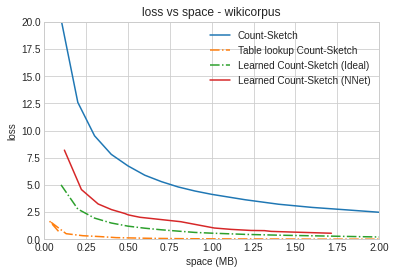

In [13]:
ALGO = 'Count-Sketch'
COUNT_MIN = 'param_results/count_sketch/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_sketch_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_sketch_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_sketch/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Sketch (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [model_size]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=LOOKUP_TABLE,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()

plot testing results for perfect CCM


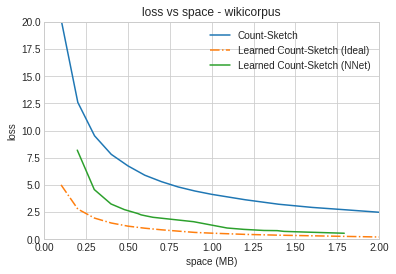

In [14]:
ALGO = 'Count-Sketch'
COUNT_MIN = 'param_results/count_sketch/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_sketch_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_sketch_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_sketch/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Sketch (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [model_size]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=None,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()